In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras import backend as K
import keras
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *
from keras.applications import MobileNetV2,Xception,ResNet50,VGG16
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import PIL
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
home_path = "/content/drive/Shareddrives/Data2040FinalProj/streetview/"
train_xml_path = home_path + 'train.xml'

In [ ]:
root = ET.parse(train_xml_path).getroot()
imgs_path = []
groundtruth_boxes = []
for i in root.iterfind('image'):
    imgs_path.append([home_path + j.text for j in i.iterfind('imageName')])
    groundtruth_boxes.append([list(r.attrib.values()) + list([t.text for t in r.iterfind('tag')]) for rs in i.iterfind('taggedRectangles') for r in rs.iterfind('taggedRectangle')])
imgs_path = np.array(imgs_path)
groundtruth_boxes = np.array(groundtruth_boxes, dtype='object')

In [ ]:
imgs_path[2][0], groundtruth_boxes[2]

('/content/drive/Shareddrives/Data2040FinalProj/streetview/img/06_08.jpg',
 [['64', '171', '756', '410', 'ANTIQUE'],
  ['54', '113', '591', '416', 'LULA'],
  ['50', '116', '927', '420', 'MALL'],
  ['35', '87', '1000', '551', 'LULA']])

In [ ]:
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

In [ ]:
X_final = []
Y_final = []
for z in range(len(imgs_path)):
    
    new_file = imgs_path[z]
    #print(new_file)
    x = cv2.imread(imgs_path[z][0])
    x_sl = 512/x.shape[1]
    y_sl = 512/x.shape[0]
    
    img = cv2.resize(x,(512,512))
       
    X_final.append(img)
    
    Y = np.zeros((grid_h,grid_w,1,5))
    
    data = groundtruth_boxes[z]
    
    for file_data in data:
        temp_list = []
        strr = file_data[4]
        bb = file_data[:4]
        
        # change for dataset center
        xmin = int(bb[2]) * x_sl
        xmax = (int(bb[2]) + int(bb[1])) * x_sl
        ymin = int(bb[3])* y_sl
        ymax = (int(bb[3]) + int(bb[0])) * y_sl
        # xmin = int(bb[0])*x_sl
        # xmax = int(bb[2])*x_sl
        # ymin = int(bb[1])*y_sl
        # ymax = int(bb[3])*y_sl
        
        # te = cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)) , color = (0,255,0))
        
        w = (xmax - xmin)/img_w
        h = (ymax - ymin)/img_h
        
        x = ((xmax + xmin)/2)/img_w
        y = ((ymax + ymin)/2)/img_h
        x = x * grid_w
        y = y * grid_h
        
        Y[int(y),int(x),0,0] = 1
        Y[int(y),int(x),0,1] = x - int(x)
        Y[int(y),int(x),0,2] = y - int(y)
        Y[int(y),int(x),0,3] = w
        Y[int(y),int(x),0,4] = h
        
    # plt.imshow(te)
    # plt.show()
    Y_final.append(Y)
    




X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5


In [ ]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.75 , shuffle = True)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((75, 512, 512, 3), (25, 512, 512, 3), (75, 16, 16, 1, 5), (25, 16, 16, 1, 5))

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

BATCH_SIZE = 4
training_set = train_datagen.flow(X_train, y=Y_train, batch_size=BATCH_SIZE)
testing_set = test_datagen.flow(X_val, y=Y_val, batch_size=BATCH_SIZE)

In [ ]:
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = tf.keras.applications.EfficientNetB7( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    model = Model(inp,final)
    
    return model

In [ ]:
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

In [ ]:
keras.backend.clear_session()
input_size = (img_h,img_w,channels)

model = yolo_model(input_size)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
opt = tf.keras.optimizers.SGD(lr=1e-5)

model.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

hist = model.fit(X_train ,Y_train ,epochs= 100 ,batch_size = 4, validation_data=(X_val,Y_val),
                 callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)])

Epoch 1/100
19/19 [==============================] - 46s 949ms/step - loss: 281.3404 - accuracy: 0.1133 - val_loss: 49.2068 - val_accuracy: 0.0430
Epoch 2/100
19/19 [==============================] - 11s 596ms/step - loss: 63.5152 - accuracy: 0.1270 - val_loss: 44.4722 - val_accuracy: 0.0589
Epoch 3/100
19/19 [==============================] - 11s 597ms/step - loss: 55.4484 - accuracy: 0.1564 - val_loss: 40.5650 - val_accuracy: 0.0725
Epoch 4/100
19/19 [==============================] - 11s 591ms/step - loss: 51.5738 - accuracy: 0.1876 - val_loss: 39.7161 - val_accuracy: 0.0763
Epoch 5/100
19/19 [==============================] - 11s 592ms/step - loss: 51.9167 - accuracy: 0.1985 - val_loss: 43.5117 - val_accuracy: 0.0806
Epoch 6/100
19/19 [==============================] - 11s 590ms/step - loss: 54.5884 - accuracy: 0.2194 - val_loss: 47.5739 - val_accuracy: 0.0841
Epoch 7/100
19/19 [==============================] - 11s 592ms/step - loss: 51.2085 - accuracy: 0.2375 - val_loss: 45.9533 

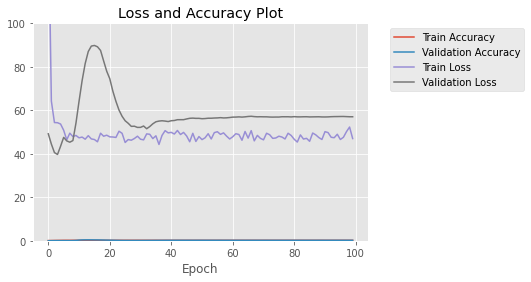

In [ ]:
import matplotlib.pyplot as plt
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), hist.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.ylim(0,100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
def decode_to_boxes(output , ht , wd):
    #output : (x,x,1,5)
    #x,y,h,w

    img_ht = ht
    img_wd = wd
    threshold = 0.5
    grid_h,grid_w = output.shape[:2]
    final_boxes = []
    scores = []

    for i in range(grid_h):
        for j in range(grid_w):
            if output[i,j,0,0] > threshold:

                temp = output[i,j,0,1:5]
                
                x_unit = ((j + (temp[0]))/grid_w)*img_wd
                y_unit = ((i + (temp[1]))/grid_h)*img_ht
                width = temp[2]*img_wd*1.3
                height = temp[3]*img_ht*1.3
                
                final_boxes.append([x_unit - width/2,y_unit - height/2 ,x_unit + width/2,y_unit + height/2])
                scores.append(output[i,j,0,0])
    
    return final_boxes,scores



def iou(box1,box2):

    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1] ,box2[1])
    y2 = min(box1[3],box2[3])
    
    inter = (x2 - x1)*(y2 - y1)
    
    area1 = (box1[2] - box1[0])*(box1[3] - box1[1])
    area2 = (box2[2] - box2[0])*(box2[3] - box2[1])
    fin_area = area1 + area2 - inter
        
    iou = inter/fin_area
    
    return iou



def non_max(boxes , scores , iou_num):

    scores_sort = scores.argsort().tolist()
    keep = []
    
    while(len(scores_sort)):
        
        index = scores_sort.pop()
        keep.append(index)
        
        if(len(scores_sort) == 0):
            break
    
        iou_res = []
    
        for i in scores_sort:
            iou_res.append(iou(boxes[index] , boxes[i]))
        
        iou_res = np.array(iou_res)
        filtered_indexes = set((iou_res > iou_num).nonzero()[0])

        scores_sort = [v for (i,v) in enumerate(scores_sort) if i not in filtered_indexes]
    
    final = []
    
    for i in keep:
        final.append(boxes[i])
    
    return final


def decode(output , ht , wd , iou):
    
    
    boxes , scores = decode_to_boxes(output ,ht ,wd)
    
    
    boxes = non_max(boxes,np.array(scores) , iou)
    
    
    return boxes

In [ ]:
def predict_func(model , inp , iou , name):
    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    print(len(boxes))
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()


    for i in boxes:

        i = [int(x) for x in i]

        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)

    plt.imshow(img)
    plt.show()
    
    cv2.imwrite(os.path.join('Results' , str(name) + '.jpg') , img*255.0)

In [ ]:
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model

In [ ]:
model_ref = load_model(home_path + 'text_detect_model.json')
model_ref.load_weights(home_path + 'text_detect.h5')

In [ ]:
model_ref.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# for layer in model_ref.layers[:-3]:
#   layer.trainable=False
# base = model_ref.output
# conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(base)
# conv = Dropout(0.4)(conv)
# bn = BatchNormalization()(conv)
# lr = LeakyReLU(alpha=0.1)(bn)

# conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
# conv = Dropout(0.4)(conv)
# bn = BatchNormalization()(conv)
# lr = LeakyReLU(alpha=0.1)(bn)

# conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
# conv = Dropout(0.4)(conv)
# bn = BatchNormalization()(conv)
# lr = LeakyReLU(alpha=0.1)(bn)

# conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)

# final = Reshape((grid_h,grid_w,classes,info))(conv)

In [ ]:
keras.backend.clear_session()
opt = tf.keras.optimizers.SGD(0.0001)

model_ref.compile(loss=yolo_loss_func , optimizer=opt , metrics = tf.keras.metrics.MeanIoU(1))
hist = model_ref.fit(X_train ,Y_train ,epochs= 200 ,batch_size = 4, validation_data=(X_val,Y_val),
                     callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)],verbose=1)

Epoch 1/200


InvalidArgumentError: ignored

In [ ]:
keras.backend.clear_session()
opt = tf.keras.optimizers.SGD(0.0001)

model_ref.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])
hist = model_ref.fit(X_train ,Y_train ,epochs= 200 ,batch_size = 4, validation_data=(X_val,Y_val),
                     callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)],verbose=1)

Epoch 1/200
19/19 [==============================] - 10s 192ms/step - loss: 15.7708 - accuracy: 0.0463 - val_loss: 16.5578 - val_accuracy: 0.0331
Epoch 2/200
19/19 [==============================] - 2s 103ms/step - loss: 13.6782 - accuracy: 0.0503 - val_loss: 15.4601 - val_accuracy: 0.0344
Epoch 3/200
19/19 [==============================] - 2s 103ms/step - loss: 13.2943 - accuracy: 0.0484 - val_loss: 14.9702 - val_accuracy: 0.0406
Epoch 4/200
19/19 [==============================] - 2s 102ms/step - loss: 11.2787 - accuracy: 0.0515 - val_loss: 14.6595 - val_accuracy: 0.0398
Epoch 5/200
19/19 [==============================] - 2s 105ms/step - loss: 11.4775 - accuracy: 0.0470 - val_loss: 14.2199 - val_accuracy: 0.0392
Epoch 6/200
19/19 [==============================] - 2s 103ms/step - loss: 11.0866 - accuracy: 0.0532 - val_loss: 14.0832 - val_accuracy: 0.0402
Epoch 7/200
19/19 [==============================] - 2s 104ms/step - loss: 10.2716 - accuracy: 0.0504 - val_loss: 13.9998 - val_a

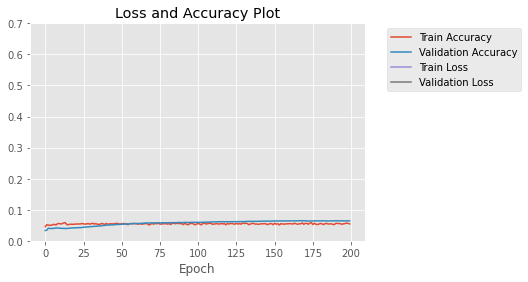

In [ ]:
import matplotlib.pyplot as plt
N = 200
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), hist.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.ylim(0,0.7)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


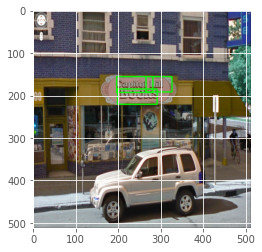

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


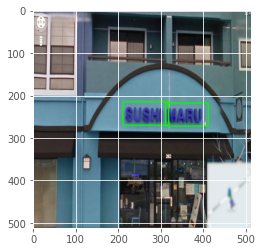

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


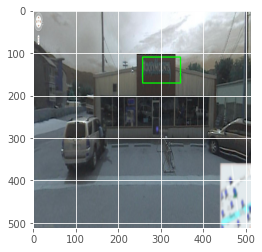

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


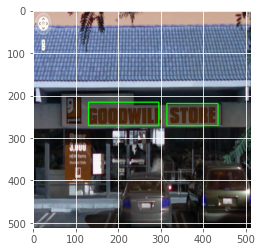

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


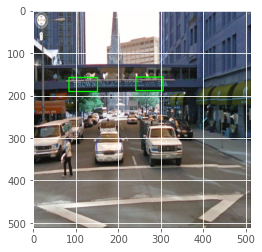

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


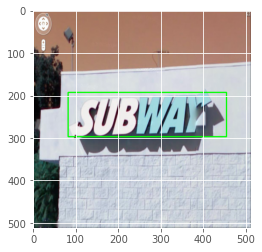

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


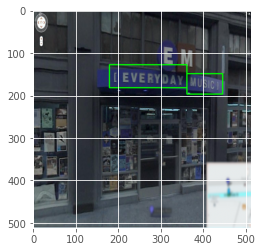

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


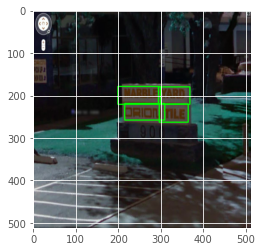

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


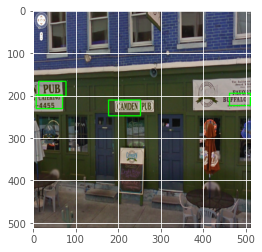

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


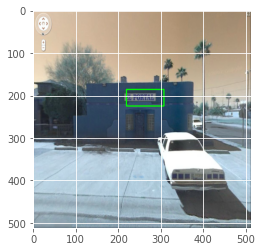

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


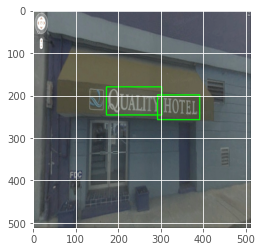

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


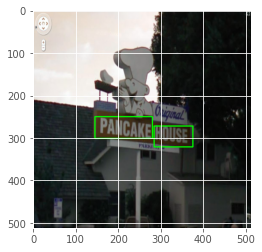

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


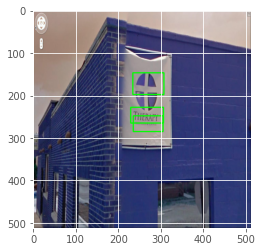

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


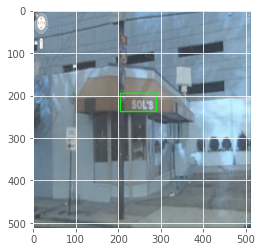

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


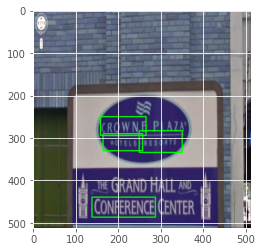

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


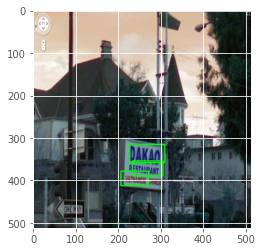

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


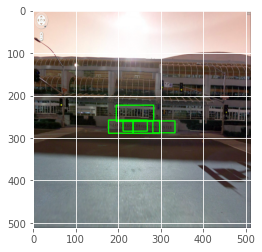

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


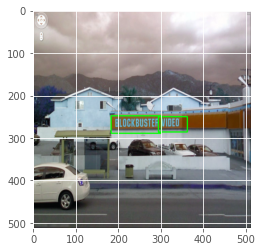

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


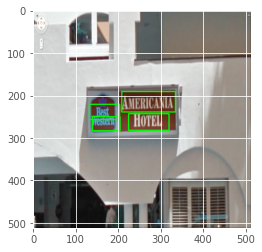

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


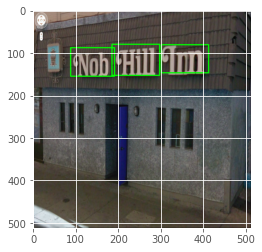

In [ ]:
for i in range(20):
    predict_func(model_ref , X_train[i:i+1] , 0.5, i)

In [ ]:
from yolov4.tf import YOLOv4

yolo = YOLOv4()

#yolo.classes = "/home/hhk7734/tensorflow-yolov4/data/classes/coco.names"

yolo.input_size = 416
yolo.make_model()
yolo.load_weights("/content/drive/MyDrive/yolo4/yolov4.weights", weights_type="yolo")

datasets = yolo.load_datasets(
    "/home/hhk7734/darknet/data/train.txt",
    datasets_type="yolo",
)

yolo.compile(learning_rate=4e-7)
yolo.fit(datasets, epochs=4000, batch_size=4)

yolo.model.save_weights("checkpoints")

In [ ]:
import torch
base_model = torch.load('/content/drive/MyDrive/yolo4/resnet_ctc.pth')